Reference:
- [CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images](https://arxiv.org/pdf/2303.14126)

# CIFAKE

In [1]:
import gdown
# Use the file ID from the shareable link
file_id = "1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti
From (redirected): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti&confirm=t&uuid=7c5a305a-3840-46e3-ae51-9072db259b24
To: /kaggle/working/data.zip
100%|██████████| 110M/110M [00:01<00:00, 55.7MB/s] 


'data.zip'

In [2]:
!unzip -q /kaggle/working/data.zip -d /kaggle/working/dataset

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
import os
import cv2 # OpenCV is used for image loading and resizing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

2025-12-03 11:08:02.706426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764760082.898336      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764760082.952864      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# 1. SETUP: Define dataset paths
# --------------------------------------------------
train_REAL = "/kaggle/working/dataset/train/REAL"
train_FAKE = "/kaggle/working/dataset/train/FAKE"
test_REAL = "/kaggle/working/dataset/test/REAL"
test_FAKE = "/kaggle/working/dataset/test/FAKE"

tf.random.set_seed(1)
np.random.seed(1)

In [6]:
# 2. DATA LOADING AND PREPARATION
# --------------------------------------------------
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        
        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (100000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


In [7]:
# 3. MODEL ARCHITECTURE
# --------------------------------------------------
print("\nBuilding the CNN model...")
model = Sequential([
    Rescaling(1./255, input_shape=(32, 32, 3)),
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Display the model's architecture
model.summary()


Building the CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1764760117.904903      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,001 (328.13 KB)

 Trainable params: 84,001 (328.13 KB)

 Non-trainable params: 0 (0.00 B)

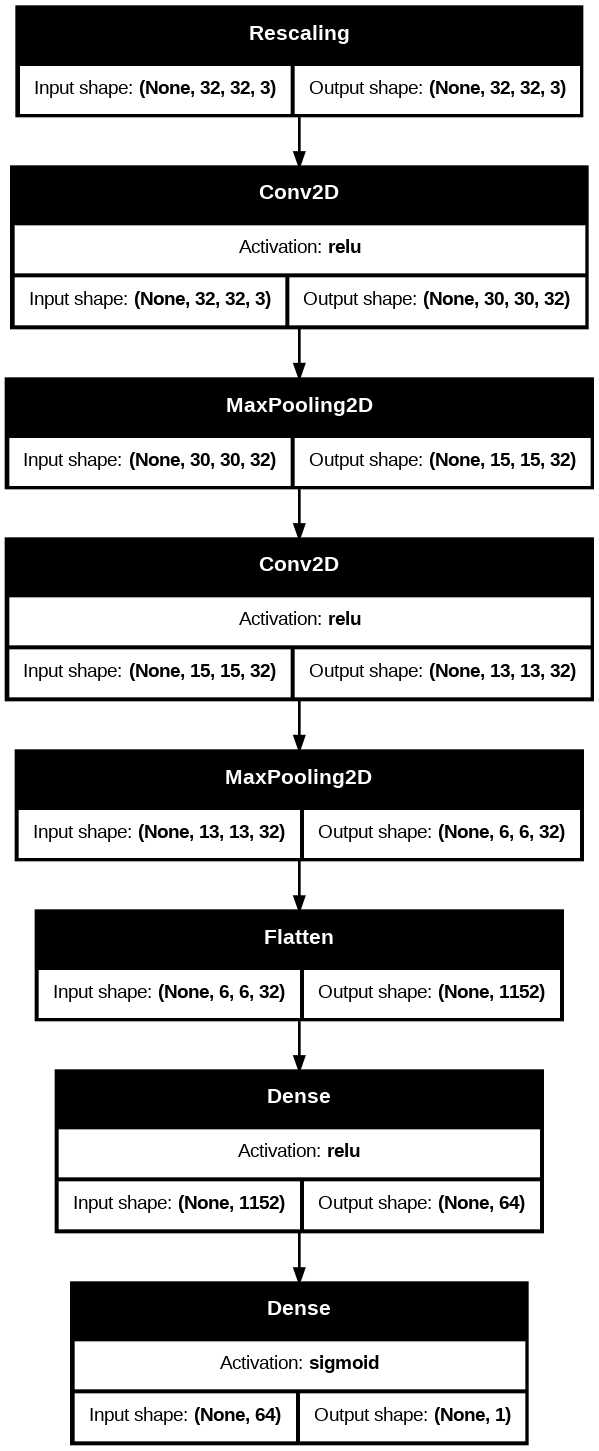

In [8]:
# 4. MODEL TRAINING AND EVALUATION
# --------------------------------------------------
print("\nCompiling the model...")
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

print("\nTraining the model...")
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64
)

print("\nEvaluating the model on the test set...")
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Loss: {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]:.4f}")
print(f"Final Test Precision: {results[2]:.4f}")
print(f"Final Test Recall: {results[3]:.4f}")


Compiling the model...

Training the model...
Epoch 1/10


I0000 00:00:1764760131.189235     100 service.cc:148] XLA service 0x7a962c00a9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764760131.189703     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764760131.484162     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  59/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5830 - loss: 0.6625 - precision: 0.5991 - recall: 0.5180  

I0000 00:00:1764760133.039391     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7850 - loss: 0.4400 - precision: 0.7747 - recall: 0.8025 - val_accuracy: 0.8957 - val_loss: 0.2544 - val_precision: 0.9085 - val_recall: 0.8801
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8956 - loss: 0.2509 - precision: 0.8926 - recall: 0.8999 - val_accuracy: 0.9118 - val_loss: 0.2207 - val_precision: 0.9476 - val_recall: 0.8719
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9173 - loss: 0.2073 - precision: 0.9155 - recall: 0.9199 - val_accuracy: 0.9233 - val_loss: 0.1950 - val_precision: 0.9440 - val_recall: 0.9001
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9269 - loss: 0.1852 - precision: 0.9260 - recall: 0.9282 - val_accuracy: 0.9293 - val_loss: 0.1806 - val_precision: 0.9464 - val_recall: 0.9100
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9328 - loss: 0.1693 - precision: 0.9319 - recall: 0.9340 - val_accuracy: 0.9321 - val_loss: 0.

In [12]:
model.save("model.h5")

In [13]:
from PIL import Image
import cv2

img = cv2.imread("/kaggle/input/personal-test/Personal test/fake/download (1).jpeg")
img = cv2.resize(img, (32, 32),interpolation=cv2.INTER_AREA)
print(img.shape)
cv2.imwrite("output.jpg", img)

(32, 32, 3)


True

In [21]:
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (32, 32),interpolation=cv2.INTER_AREA)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

per_REAL = "/kaggle/input/personal-test/Personal test/real"
per_FAKE = "/kaggle/input/personal-test/Personal test/fake"
per_real_images, per_real_labels = load_images_from_folder(per_REAL, 1)
per_fake_images, per_fake_labels = load_images_from_folder(per_FAKE, 0)

print(per_real_images.shape)
print(per_fake_images.shape)
X_per = np.concatenate((per_real_images, per_fake_images), axis=0)
y_per = np.concatenate((per_real_labels, per_fake_labels), axis=0)


train_indices = np.arange(X_per.shape[0])
np.random.shuffle(train_indices)
X_per = X_per[train_indices]
y_per = y_per[train_indices]


print(f"\nTraining data shape: {X_per.shape}")

(5, 32, 32, 3)
(5, 32, 32, 3)

Training data shape: (10, 32, 32, 3)


In [22]:
y_pred_proba = model.predict(X_per)

y_pred = (y_pred_proba > 0.5).astype("int32")

report = classification_report(y_per, y_pred, target_names=['FAKE (0)', 'REAL (1)'], digits=4)
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
              precision    recall  f1-score   support

    FAKE (0)     0.7143    1.0000    0.8333         5
    REAL (1)     1.0000    0.6000    0.7500         5

    accuracy                         0.8000        10
   macro avg     0.8571    0.8000    0.7917        10
weighted avg     0.8571    0.8000    0.7917        10

